In [0]:
# Let MNIST(alpha) be MNIST with Gaussian noise of SD alpha added to the pixels.
# Group any five classes to be the positive class and the rest to be the negative class.
# Add a 3x3 patch on the left/right based on whether the image is positive or negative. Let's call these modified datasets as MNIST_bin_patch(alpha).
# Also define the patchless versions of these datasets as MNIST_bin(alpha).
# Train a linear model on these datasets for an appropriate range of alpha values. Only select architectures that have good training and testing performance on the 
# patchless version of the dataset (this is to rule out really bad architectures and really bad datasets).

# Test all these models (trained on the patched version of the data) on the test set of MNIST_bin_patch(alpha), MNIST_bin(alpha), i.e. the model is tested on the data 
# with which it is trained, and also the patchless version. Choose the model/dataset for which the difference between the two is greatest. 
# (The accuracy on the patched data is much higher than the accuracy on the data without patches). 
# Now the goal is to train a model with the same architecture of the chosen model that does well on both the patched data and the patchless data. 



# Model learns beter when trained on the dat awith partches than eithout patches!
# In case of training on no patches, 
# for 1 classifier, loss starts with 
# for 2 classifiers with lambda = 0, loss starts from 612...Training and test loss (on patchless data) is around 89%
# for 2 classifiers with lambda = 1, loss starts from 636...Training and test loss (on patchless data) is around 89%

# In case of training with patches (28*4)
# for 2 classifier, with lambda = 1, loss starts from 10.7...training accuracy is 100%, test acc on path data is 100 and that on patchless is around 80%

# In case of training with patches (3*3)
#######################
# For 2 classifiers with 0 lambda, model clearly learns patches as apparent from the weight vector images

#######################
# for 2 classifier, with lambda = 1, loss starts from 10.7...training accuracy is 100%, test acc on path data is 100 and that on patchless is around 80%

# The test accuracy on patchless data is highest when trained on patch less data (89% for both test and train).
# As the size of patch grows, train accuracy grows to 100%, while test accuracy on patchless data reduces. Test accuracy on data with patches is 100%.
# So as the patch size grows, the model begins to primrily learn the left-right patch rather than odd-even
# Even the newly added dot product loss doesn't seem to make the 2 classifiers learn different tasks

# Even the fancy dot product loss seems to learn both the tasks for both models
# It tries to make the vectors orthogonal in the parts except the patches


# data type matters because conversion to float and again to int gives the same results as no conversion...

In [0]:
# For improving the model expeiments, alpha = 150. Test accuracy on patchless data falls from 82% to 63% for a 3*3 patch

In [0]:
alpha = 100 # taking 150 because visually makes more sense for human eye
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

trainset_forpatch = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset_forpatch = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

In [0]:
# label [1, 2, 3, 4, 5] as 0, others as one
trainset.targets[np.where(trainset.targets %2 != 0)[0].tolist()] = 1
trainset.targets[np.where(trainset.targets %2 == 0)[0].tolist()] = 0

testset.targets[np.where(testset.targets %2 != 0)[0].tolist()] = 1
testset.targets[np.where(testset.targets %2 == 0)[0].tolist()] = 0

trainset_forpatch.targets[np.where(trainset_forpatch.targets %2 != 0)[0].tolist()] = 1
trainset_forpatch.targets[np.where(trainset_forpatch.targets %2 == 0)[0].tolist()] = 0

testset_forpatch.targets[np.where(testset_forpatch.targets %2 != 0)[0].tolist()] = 1
testset_forpatch.targets[np.where(testset_forpatch.targets %2 == 0)[0].tolist()] = 0

In [0]:
# Converting the data type to float in order to be able to add Gaussian noise
trainset.data = trainset.data.type(torch.float64)
testset.data = testset.data.type(torch.float64)
trainset_forpatch.data = trainset_forpatch.data.type(torch.float64)
testset_forpatch.data = testset_forpatch.data.type(torch.float64)

In [0]:
# Generating MNIST_bin(alpha)
def GaussianNoise_alpha(trainset1, testset1, alpha):
  for im in range(len(trainset1)):
#     trainset1.data[im] = torch.tensor(trainset1.data[im], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = trainset1.data[im] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = np.clip(trainset1.data[im], 0, 255)
  for jm in range(len(testset1)):
#     testset1.data[jm] = torch.tensor(testset1.data[jm], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    testset1.data[jm] = testset1.data[jm] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    testset1.data[jm] = np.clip(testset1.data[jm], 0, 255)
  return trainset1, testset1


# Generating MNIST_bin_patch(alpha)
def GaussianNoise_alpha_patch(trainset1, testset1): # Feed in the data with gaussian noise already added
# Left patch for   
  for im in range(len(trainset1)):
    if trainset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          trainset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          trainset1.data[im][p1, p2] = 255

  for im in range(len(testset1)):
    if testset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          testset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          testset1.data[im][p1, p2] = 255
          
  return trainset1, testset1 

In [0]:
# Creating the bin data
train_bin, test_bin = GaussianNoise_alpha(trainset, testset, alpha)

# # Creating the bin data with patches
train_inter, test_inter = GaussianNoise_alpha(trainset_forpatch, testset_forpatch, alpha)
train_bin_patch, test_bin_patch = GaussianNoise_alpha_patch(train_inter, test_inter)

In [0]:
# Converting the data type back to unit8...

train_bin.data = train_bin.data.type(torch.uint8)
test_bin.data = test_bin.data.type(torch.uint8)
train_bin_patch.data = train_bin_patch.data.type(torch.uint8)
test_bin_patch.data = test_bin_patch.data.type(torch.uint8)

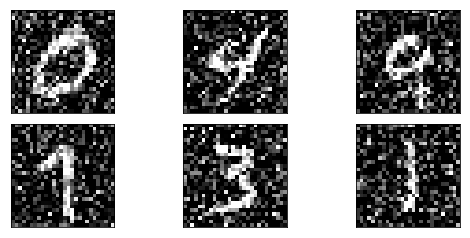

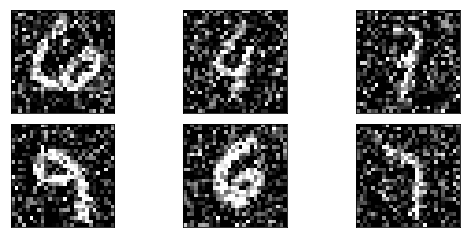

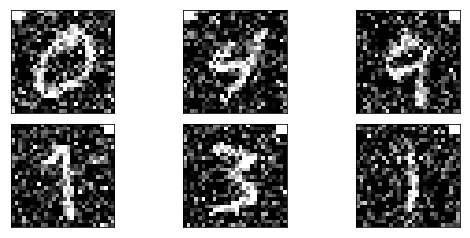

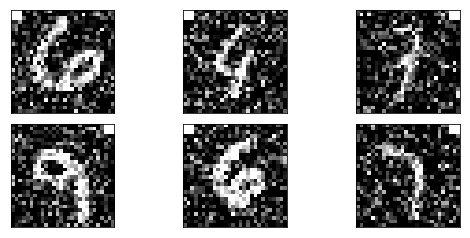

In [8]:
# Plot random train and test images
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(train_bin.data[i], cmap='gray')
    
#Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(test_bin.data[i], cmap='gray')  
    
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(train_bin_patch.data[i], cmap='gray')
    
# Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(test_bin_patch.data[i], cmap='gray')      

In [0]:
# Assign data to data loader

trainloader = torch.utils.data.DataLoader(train_bin, batch_size = 64, shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(test_bin, batch_size = 64, shuffle = False, num_workers = 2)

trainloader_patch = torch.utils.data.DataLoader(train_bin_patch, batch_size = 64, shuffle = True, num_workers = 2)

testloader_patch = torch.utils.data.DataLoader(test_bin_patch, batch_size = 64, shuffle = False, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.fc1 = nn.Linear(28*28, 1)
    self.fc2 = nn.Linear(28*28, 1)
#     self.fc3 = nn.Linear(28*28, 1)
#     self.fc4 = nn.Linear(28*28, 1)
    
  def forward(self, x):
    x = x.view(-1, 28*28)
    x1 = torch.sigmoid(self.fc1(x))  
    x2 = torch.sigmoid(self.fc2(x))  
#     x3 = torch.sigmoid(self.fc3(x))  
#     x4 = torch.sigmoid(self.fc4(x))  
    return x1, x2#, x3, x4
  
model = linear_model()  

In [0]:
#Script for generating fancy inner product matrix:

sigma = 0.01
M = torch.zeros([28*28, 28*28])

M_tensor = M.view(28,28,28,28)

for i_1 in range(28):
    for i_2 in range(28):
        for j_1 in range(28):
            for j_2 in range(28):
                M_tensor[i_1,i_2,j_1,j_2] = np.exp( -((i_1 - j_1)**2 + (i_2 - j_2)**2)/(2 * (sigma)**2) )

M = M_tensor.view([28*28,28*28])

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function = nn.BCELoss(reduction = 'mean') # sums all outputs and divides by total data points

optimizer = optim.Adam(model.parameters(), lr = 0.001)

class custom_loss(torch.nn.Module):

  def __init__(self):
    super(custom_loss,self).__init__()

  def forward(self, mat1, mat2, M):
  # Absolute dot product of weights
#     l = (torch.mm(mat1, mat2.t()))**2

  # Fancy dot product if weights
    l = (torch.mm(mat1, torch.mm(M, mat2.t())))**2
    return l

sl = custom_loss()    

In [13]:
n_epochs = 10
lmbda = 500

for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in trainloader_patch:
    data, targets = batch
    
    optimizer.zero_grad()
    
    output1, output2 = model(data)
    
    loss = loss_function(output1, targets.float()) + loss_function(output2, targets.float()) + lmbda * sl.forward(model.fc1.weight, model.fc2.weight, M) 
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
  print(running_loss)    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


173.17666628584266


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


40.58459556661546
29.678987061604857
24.815524850040674
21.241325228475034
19.137058389373124
17.515722639858723
16.638742349110544
15.16005245782435
14.323697049170732


In [23]:
sl(model.fc2.weight, model.fc1.weight, M)

tensor([[1.6972e-09]], grad_fn=<PowBackward0>)

In [15]:
# # Test performance on the entire test set
# correct = 0
# total = 0
# with torch.no_grad():
#   for data in testloader:
#     images, labels = data
#     outputs = model(images)
# #     _, predicted = torch.max(outputs, 1)
#     predicted = outputs > 0.5
# #     predicted = predicted.view(predicted.size(0))
#     total += labels.size(0)
#     matches = 0
#     for i in range(len(predicted)):
#       if predicted[i].item() == labels[i].item():
#         matches += 1
#     correct += matches#(predicted == labels).sum().item()
#   print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs[0] > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 73 %


In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in trainloader_patch:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader_patch:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


<Figure size 432x288 with 0 Axes>

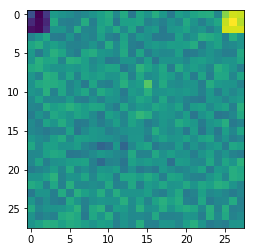

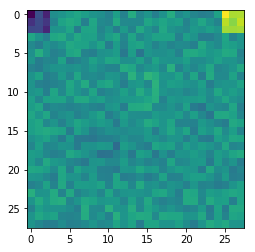

<Figure size 432x288 with 0 Axes>

In [0]:
W1 = model.fc1.weight.detach().numpy()
W1_reshape = np.reshape(W1, (28, 28))
plt.imshow(W1_reshape)
plt.figure()

W2 = model.fc2.weight.detach().numpy()
W2_reshape = np.reshape(W2, (28, 28))
plt.imshow(W2_reshape)
plt.figure()

# W3 = model.fc3.weight.detach().numpy()
# W3_reshape = np.reshape(W3, (28, 28))
# plt.imshow(W3_reshape)
# plt.figure()

# W4 = model.fc4.weight.detach().numpy()
# W4_reshape = np.reshape(W4, (28, 28))
# plt.imshow(W4_reshape)
# plt.figure()

In [0]:
# # Tabluate the train and test accuracy on the un-patched data for different values of SD (alpha)
# train_accuracy = [0.89, 0.86, 0.82, 0.81, 0.69]
# test_accuracy = [0.89, 0.85,0.82, 0.80, 0.67]
# alphas_ = [1, 100, 150, 200, 500]

In [0]:
# # Choose value of alpha as 2 for further analysis

# ### Training on patches (4*4 patch)
# train_acc_patch = [1, 1 ,1]
# test_acc_patch = [1,1 ,1]
# test_acc_patchless = [0.77, 0.68, 0.64]

# ### Training on patches (3*3 patch)
# train_acc_patch = [1, 1, 1]
# test_acc_patch = [1, 1, 1]
# test_acc_patchless = [0.74, 0.66, 0.62]

In [0]:
# for sigma = 0.01, lmbda = 500, accuracy is 67% in 10 epochs